<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/V5_2_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten,TimeDistributed
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/Final_Feature_kospi_sen_all.csv')
stock_data

,Date,Kospi_close,Kospi_high,ko_interest,oil_open,ex_JP_low,gold_low,us500_low,klue_bert_score_summarize_content,oil_vol,research_kospi,dji_vol,us500_vol,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,klue_bert_score_title
0,20210105,2990.57,0.795,0.0,0.213,0.590,0.661,0.581,-0.536,0.013,0.413,0.280,0.349,0.157,0.195,0.823
1,20210106,2968.21,0.819,0.0,0.219,0.596,0.650,0.585,1.381,0.006,0.628,0.470,0.527,1.236,0.569,0.722
2,20210107,3031.68,0.839,0.0,0.225,0.597,0.670,0.608,1.845,0.007,0.427,0.378,0.410,0.537,1.395,-0.675
3,20210108,3152.18,0.855,0.0,0.230,0.584,0.631,0.615,2.497,0.004,0.512,0.318,0.371,0.697,-1.382,1.124
4,20210111,3148.45,0.914,0.0,0.232,0.584,0.623,0.617,-0.951,0.009,0.881,0.287,0.334,0.331,-0.044,0.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20230623,2570.10,0.601,1.0,0.651,0.028,0.212,0.830,0.402,0.000,0.125,0.316,0.526,0.834,-0.339,0.831
584,20230626,2582.20,0.602,1.0,0.651,0.024,0.212,0.825,-0.385,0.000,0.120,0.170,0.207,-0.196,0.681,-0.001
585,20230627,2581.39,0.594,1.0,0.651,0.000,0.208,0.828,-0.447,0.000,0.118,0.206,0.226,-0.208,0.625,-0.097
586,20230628,2564.19,0.592,1.0,0.651,0.011,0.217,0.838,0.777,0.000,0.128,0.174,0.246,1.099,0.892,0.253


In [3]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)

In [4]:
name = [stock_data.columns]

close_1 = ['klue_bert_score_summarize_content',
        'kofinbert_score_summarize_content_kospi']

stock_data_1 = stock_data.drop(close_1, axis=1)

In [5]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t_1, test_data_t_1 = stock_data_1[:train_size], stock_data_1[train_size:]
train_data_t_2, test_data_t_2 = stock_data[:train_size], stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t_1, train_data, look_back)
testX, testY = create_dataset(test_data_t_1,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(489, 10, 12)
(489, 1)
(79, 10, 12)
(79, 1)


In [6]:
def accuracy(list1,list2):
  list1 = list1.flatten().tolist()
  list2 = list2.flatten().tolist()
  value_1 = []
  value_2 = []
  j = 0
  if len(list1) == len(list2):
    for i in range(len(list1)-1):
      if list1[i+1] > list1[i]:
        value_1.append(1)
      elif list1[i+1] == list1[i]:
        value_1.append(0)
      else:
        value_1.append(-1)
    for i in range(len(list1)-1):
      if list2[i+1] > list2[i]:
        value_2.append(1)
      elif list2[i+1] == list2[i]:
        value_2.append(0)
      else:
        value_2.append(-1)
    for i in range(len(value_1)):
      if value_1[i] == value_2[i]:
        j = j + 1
    accuracy = j/len(value_1) * 100
    print("accuracy : %d" % accuracy)
  else:
    print("길이가 다릅니다.")

In [7]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 751/2000

Epoch 751: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 301955.7500 - val_loss: 11630.3174 - 502ms/epoch - 72ms/step
Epoch 752/2000

Epoch 752: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 326866.0938 - val_loss: 35405.6289 - 502ms/epoch - 72ms/step
Epoch 753/2000

Epoch 753: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 330380.8438 - val_loss: 43678.2148 - 540ms/epoch - 77ms/step
Epoch 754/2000

Epoch 754: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 355838.9062 - val_loss: 34171.3711 - 504ms/epoch - 72ms/step
Epoch 755/2000

Epoch 755: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 303996.7188 - val_loss: 47416.3828 - 501ms/epoch - 72ms/step
Epoch 756/2000

Epoch 756: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 294224.3125 - val_loss: 38807.2812 - 504ms/epoch - 72ms/step
Epoch 757/2000

Epoch 757: val_loss did not improve from 4927.70703
7/7 - 1s - loss: 328

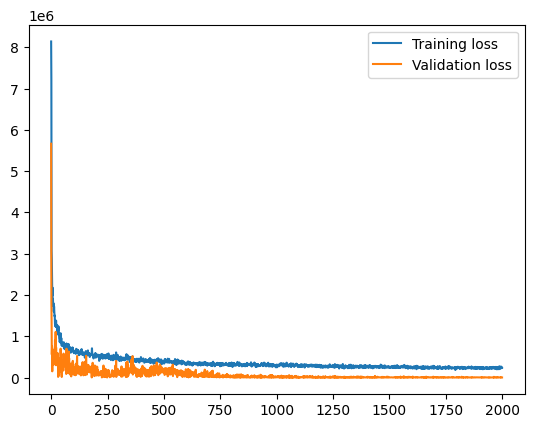

3/3 [==============================] - 0s 19ms/step
Training MSE: 8510.201
Testing MSE: 11746.686
Training MAPE: 2.617%
Testing MAPE: 3.714%
accuracy : 55


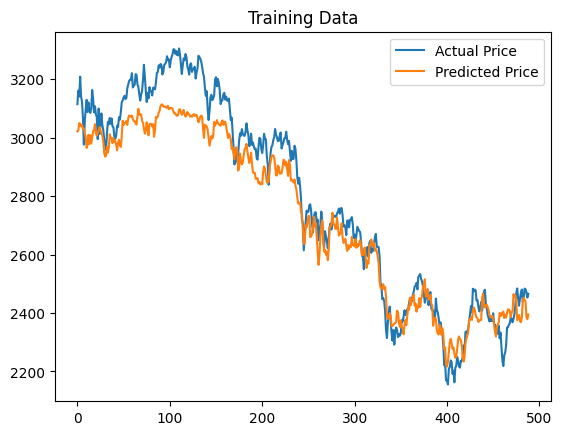

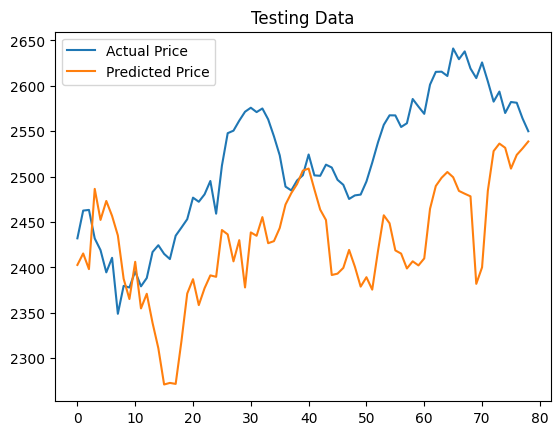

In [8]:
# 모델 생성 GRU+CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=2000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_sum_CNN_GRU__weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

# MAPE 계산
trainMAPE = calculate_mape(trainY, trainPredict)
testMAPE = calculate_mape(testY, testPredict)

print(f'Training MSE: {trainMSE:.3f}')
print(f'Testing MSE: {testMSE:.3f}')
print(f'Training MAPE: {trainMAPE:.3f}%')
print(f'Testing MAPE: {testMAPE:.3f}%')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [9]:
trainX, trainY = create_dataset(train_data_t_2, train_data, look_back)
testX, testY = create_dataset(test_data_t_2,test_data, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(489, 10, 14)
(489, 1)
(79, 10, 14)
(79, 1)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 751/2000

Epoch 751: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 325890.1875 - val_loss: 26428.4746 - 545ms/epoch - 78ms/step
Epoch 752/2000

Epoch 752: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 307848.8125 - val_loss: 53004.3633 - 571ms/epoch - 82ms/step
Epoch 753/2000

Epoch 753: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 329421.9062 - val_loss: 30690.0410 - 515ms/epoch - 74ms/step
Epoch 754/2000

Epoch 754: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 309530.4062 - val_loss: 27650.1895 - 651ms/epoch - 93ms/step
Epoch 755/2000

Epoch 755: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 323929.3750 - val_loss: 19012.9648 - 1s/epoch - 145ms/step
Epoch 756/2000

Epoch 756: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 356378.5938 - val_loss: 28550.0430 - 1s/epoch - 149ms/step
Epoch 757/2000

Epoch 757: val_loss did not improve from 5486.62988
7/7 - 1s - loss: 303088.

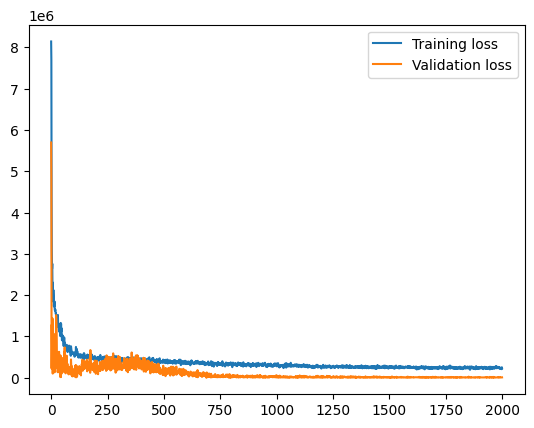

3/3 [==============================] - 0s 21ms/step
Training MSE: 5993.667
Testing MSE: 15675.788
Training MAPE: 2.366%
Testing MAPE: 4.506%
accuracy : 58


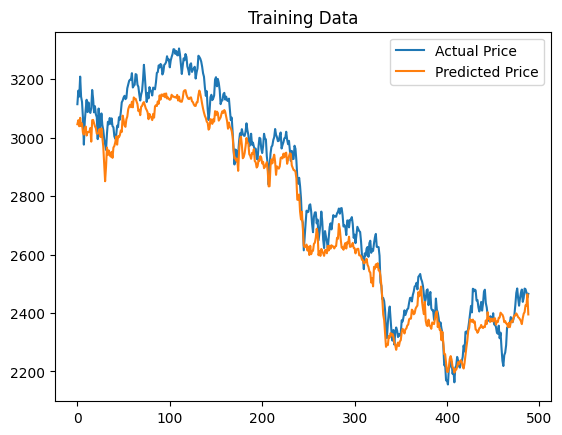

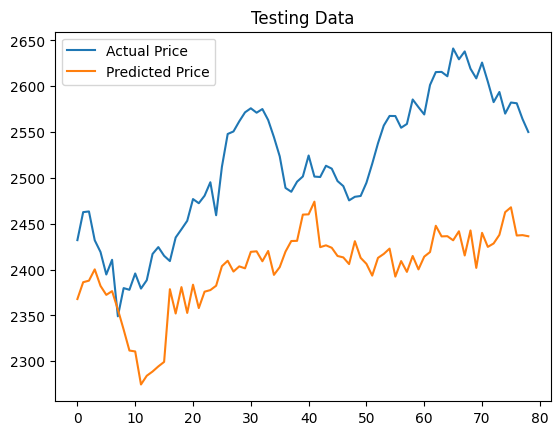

In [10]:
# 모델 생성 GRU+CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=2000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_sum_CNN_GRU__weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

# MAPE 계산
trainMAPE = calculate_mape(trainY, trainPredict)
testMAPE = calculate_mape(testY, testPredict)

print(f'Training MSE: {trainMSE:.3f}')
print(f'Testing MSE: {testMSE:.3f}')
print(f'Training MAPE: {trainMAPE:.3f}%')
print(f'Testing MAPE: {testMAPE:.3f}%')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()